In [19]:
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl

import flamedisx as fd

import os
import glob

import collections

In [20]:
def get_disco_bands(directory):
    all_exposures = []
    all_bands = []
    
    subfolders = [f.path for f in os.scandir(directory) if f.is_dir() and len(glob.glob(f'{f.path}/*.pkl')) > 0]
    for subfolder in subfolders:
        all_exposures.append(float(subfolder.split('_')[-1][:-2]))
    
        disco_sigs = pkl.load(open(f'{subfolder}/disco_sigs_0.pkl', 'rb'))
        intervals = fd.IntervalCalculator(signal_source_names=['WIMP'],
                                          stat_dists=disco_sigs)

        bands, mus = intervals.get_bands_discovery()
        all_bands.append(bands['WIMP'][mus['WIMP'][0]])

    return all_exposures, all_bands

In [21]:
def get_crossing(x, y, crit_val=5.):
    crossing_points = np.argwhere(np.diff(np.sign(y - np.ones_like(y) * crit_val)) > 0.).flatten()
    
    try:
        x_left = x[crossing_points[0]]
        x_right = x[crossing_points[0] + 1]
        y_left = y[crossing_points[0]]
        y_right = y[crossing_points[0] + 1]
    except:
        
        return x[-1]
    
    gradient = (y_right - y_left) / (x_right - x_left)


    return (crit_val - y_left) / gradient + x_left #re-arranged y-b = m(x-a) or (y-b)/m + a = x

In [22]:
files_titles = {'/global/homes/r/rory_m/rory_m/XLZD/FlameFitSimple/analyses/WIMP_discovery/outputs/WIMP_disco/benchmark_0.05395_more_exposure': 'Benchmark parameters'}

In [23]:
def produce_plot(file, title):
    exposures, bands = get_disco_bands(directory=file)
    
    plt.figure()
    delta = 5

    medians = dict()
    for exposure, band in zip(exposures, bands):

        plt.plot([exposure-delta, exposure+delta],
                 2*[band[0]],
                 color='k', linewidth=2)
        plt.fill_between([exposure-delta, exposure+delta],
                         2*[band[-1]], 2*[band[1]],
                         facecolor='#00ff00', alpha=0.5)
        plt.fill_between([exposure-delta, exposure+delta],
                         2*[band[-2]], 2*[band[2]],
                         facecolor='#ffff00', alpha=0.5)

        medians[exposure] = band[0]

    medians = collections.OrderedDict(sorted(medians.items()))
    exposures = list(medians.keys())
    meds = list(medians.values())
    crossing = get_crossing(exposures, meds)
    
    plt.hlines(5., np.min(exposures), np.max(exposures), color='darkred', linestyle='--', linewidth=1)
    plt.text(np.min(exposures), 5.2, 'Discovery', color='darkred')

    plt.xlabel("Exposure [ty]")
    plt.ylabel("Discovery potential [$\sigma$]")
    plt.title(f"{title}: {crossing:.2f} ty")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(0,10)
    ax = plt.gca()
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)

    #plt.ylim (0., 10.)

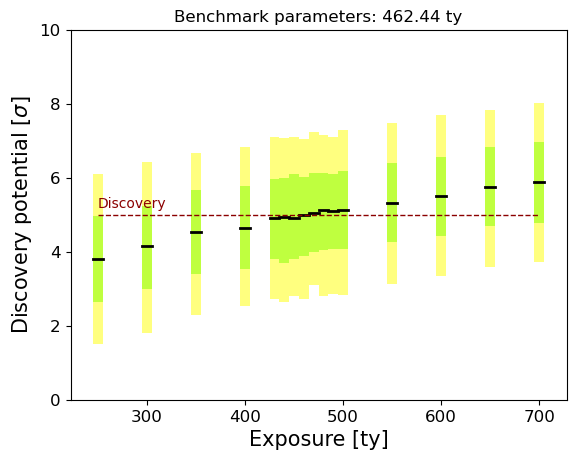

In [24]:
for file, title in files_titles.items():
    produce_plot(file, title)